In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import xbout
import scipy
import xhermes

sys.path.append(r"C:\Users\Mike\OneDrive\Project\python-packages\sdtools")

from hermes3.utils import *


from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.selectors import *

%load_ext autoreload
%autoreload 2
print("Done")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


# Intro
- This notebook gives a brief introduction to post-processing 2D simulations in Hermes-3.
- These are currently in my personal repo sdtools but will be ported over to xHermes.
- For now sdtools is a wrapper around xHermes which adds functionality.

## Read Hermes-3
- CaseDB is a class which automatically scans for simulations and finds the paths to their grids.
- Note that by default, we squash the simulation on load. This combines all the output files into one, reducing Xarray overhead and significantly improving loading times after the first time.

In [ ]:
db = CaseDB(
    case_dir = r"C:\Users\Mike\OneDrive\Project\collab\tech\cases",
    grid_dir = r"C:\Users\Mike\OneDrive\Project\collab\tech\grid"
)

toload = [ 
    dict(name="base", id="m6b-next_moredetached", unnormalise_geom = True, use_xhermes = True, squash = True), 
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)
    cs[case["name"]].extract_2d_tokamak_geometry()  # This is required for geometry normalisation, calculation of volume etc


- Reading case m6b-next_moredetached
-----------------------
- Looking for squash file
- Squash file found. squash date 02/22/2025, 16:07:17, dmp file date 02/22/2025, 15:54:49

Unnormalising with xHermes


# Useful metadata

## Species
- Info on species in the model.

In [ ]:
m = cs["base"].ds.metadata

print(f'Species in model: \n {m["species"]}')
print(f'\nCharged species: \n {m["charged_species"]}')
print(f'\nIon species: \n {m["ion_species"]}')
print(f'\nNeutral species: \n {m["neutral_species"]}')
print(f'\nRecycling pairs: \n {m["recycling_pairs"]}')

Species in model: 
 ['d', 'd+', 'e']

Charged species: 
 ['d+', 'e']

Ion species: 
 ['d+']

Neutral species: 
 ['d']

Recycling pairs: 
 {'d+': 'd'}


## Geometry
- The metadata contains all the branch cuts as per the BOUT++ docs: https://bout-dev.readthedocs.io/en/stable/user_docs/input_grids.html
- jyseps1_1 etc have been simplified to j1_1 etc.
- For each version of the branch cut there is one without guards included, these have a "g" suffix, e.g. j1_1g.
- There are also midplane indices. If the cellcount is even in the SOL, there won't be a cell centre exactly on the midplane. omp_a and omp_b are the cells above and below it. There is also imp_a and imp_b.

# Selection
- The method ds.hermesm.select_region() returns a dataset containing only the desired selection.
- The method select_custom_sol_ring() returns a selection of a field line for any of the regions (e.g. inner_lower, outer_upper). You can provide either the SOL ring index (sepadd, i.e. how many rings past separatrix) or separatrix distance (e.g. sepdist = 0.001)
- The method select_custom_core_ring() returns a core ring for a given index where i=0 is the core edge.

**Please see the contents of sdtools.hermes3.accessors._select_region for all the possible regions.**

76 106


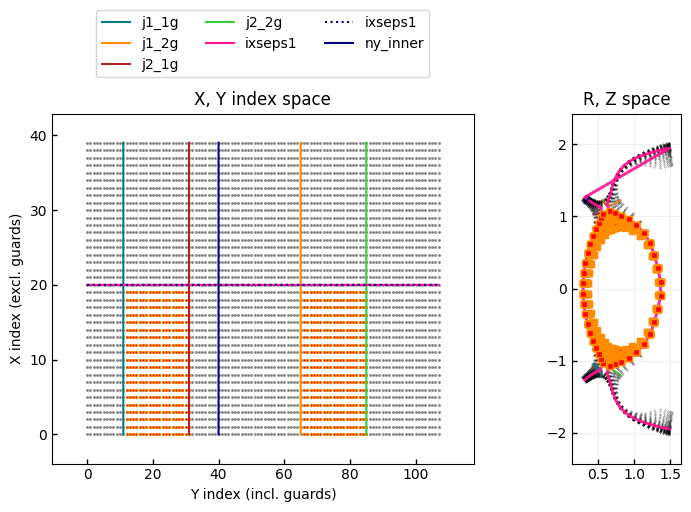

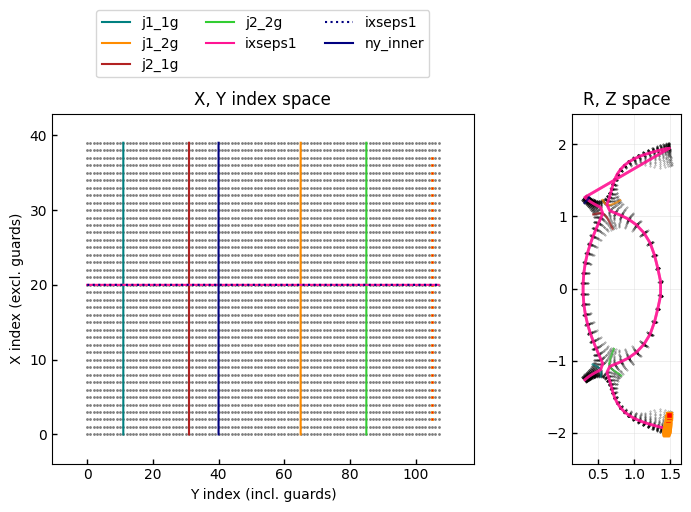

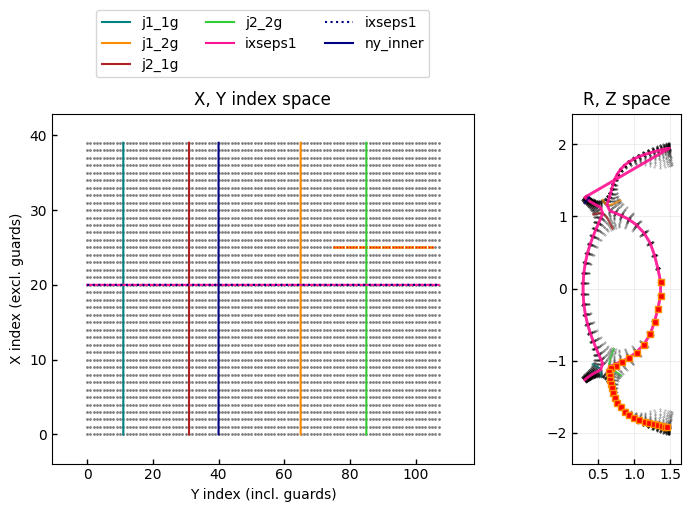

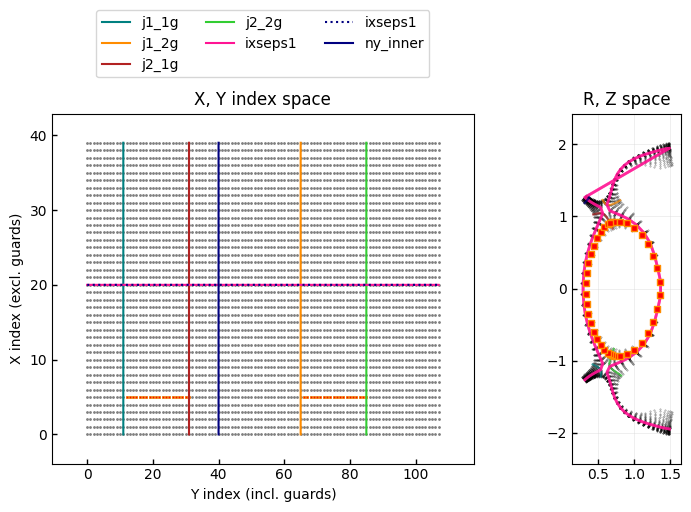

In [ ]:
ds = cs["base"].ds.isel(t=-1)  # Select last time slice

plot_selection(ds, ds.hermesm.select_region("core"))
plot_selection(ds, ds.hermesm.select_region("outer_lower_target"))
plot_selection(ds, ds.hermesm.select_custom_sol_ring(sepadd = 5, region = "outer_lower"))  # Select 5th SOL ring
plot_selection(ds, ds.hermesm.select_custom_core_ring(i = 3))  # Select 3rd core ring

# Using selection to plot quantities of interest

## Plot of separatrix density evolution

Text(0.5, 1.0, 'Separatrix density evolution')

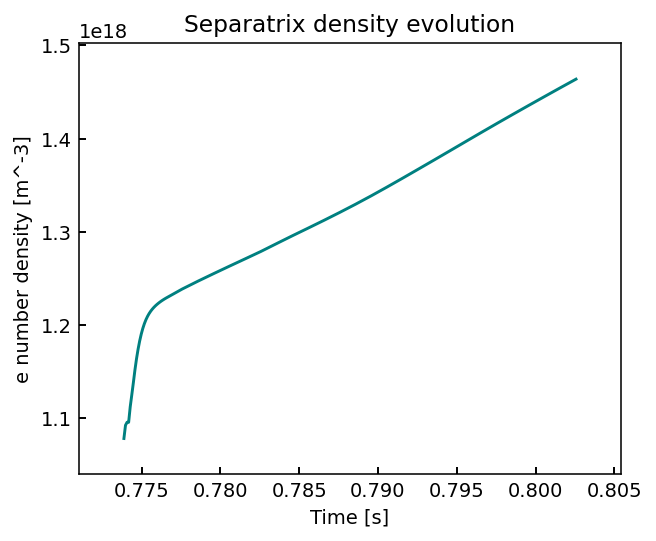

In [12]:
ds = cs["base"].ds
ds.hermesm.select_region("outer_midplane_a_sep")["Ne"].plot()
plt.title("Separatrix density evolution")

## Plot target temperature history
- Note that guard cells are included by default

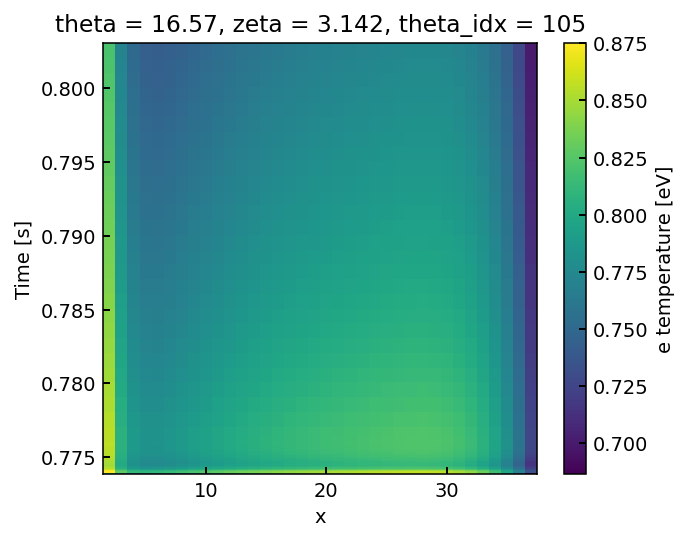

In [ ]:
ds = cs["base"].ds
ds.hermesm.select_region("outer_lower_target")["Te"].plot()
plt.title("Target temperature history")

# Plotting radial and poloidal information
## get_1d_poloidal_data
This obtains variables along a poloidal slice for a given region, e.g. outer_lower or inner_upper. You can define the SOL ring by the offset from separatrix (sepadd) or distance from separartrix (sepdist). Both poloidal distance Spol and parallel distance Spar are provided. The results are saved in a Pandas dataframe for convenience. Guard replacement is not included yet.

76 106


,Z,dpar,Spol,Spar,Te,Td+,Td
26,-1.891140,1.028292,2.462933,20.473817,1.436696,1.418629,1.391697
27,-1.906233,1.006700,2.518862,21.480516,1.125734,1.129845,1.129584
28,-1.918517,0.912449,2.566469,22.392965,1.016021,1.019596,1.020569
29,-1.927684,0.759186,2.604576,23.152151,0.964776,0.969793,0.971527
30,-1.933782,0.559746,2.632045,23.711897,0.851634,0.935947,0.949080


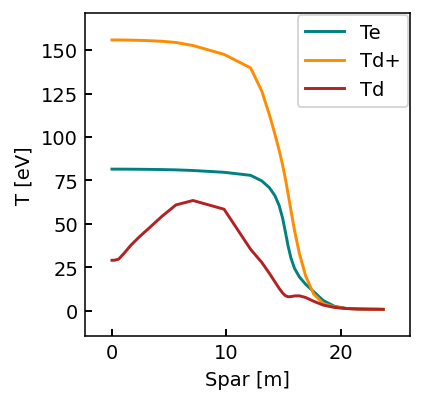

In [49]:
ds = cs["base"].ds.isel(t=1)
df_fieldline = get_1d_poloidal_data(ds, params = ["Te", "Td+", "Td"], region = "outer_lower", sepdist = 0.001)
display(df_fieldline.tail(5))

fig, ax = plt.subplots(figsize = (3,3))
ax.plot(df_fieldline["Spar"], df_fieldline["Te"], label = "Te")
ax.plot(df_fieldline["Spar"], df_fieldline["Td+"], label = "Td+")
ax.plot(df_fieldline["Spar"], df_fieldline["Td"], label = "Td")
ax.set_xlabel("Spar [m]")
ax.set_ylabel("T [eV]")
ax.legend()

### get_1d_radial_data
This does the same but for radial slices. If region == "omp" or "imp", it will interpolate values onto the midplane (recall there are no cell centres exactly on midplane). If region is some other word, it will pass it to select_region and use as-is.
- OMP and IMP exclude guards by default. If another region is selected, the selection determines if it has guards or not.
- The coordinates provided are "Srad" which is in metres from separatrix. 
- There is also a column showing which point is just after the separatrix.

,dr,Te,Td+,Td,Srad,sep
31,0.001638,18.560053,93.761621,26.195125,0.010248,0
32,0.001843,15.728511,87.581679,25.660738,0.011989,0
33,0.002062,13.507453,82.086870,25.067476,0.013941,0
34,0.002298,11.888702,77.692526,24.416524,0.016121,0
35,0.002548,10.950555,75.035280,23.744974,0.018544,0


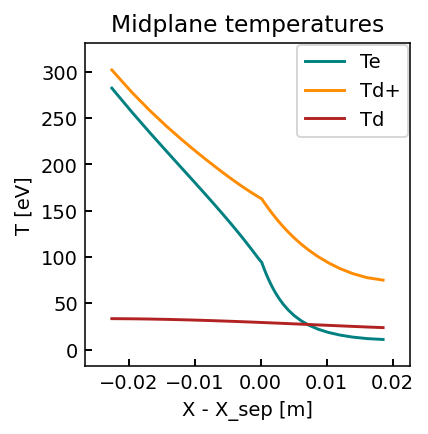

In [53]:
df_midplane = get_1d_radial_data(ds, params = ["Te", "Td+", "Td"], region = "omp")
display(df_midplane.tail(5))

fig, ax = plt.subplots(figsize = (3,3))
ax.plot(df_midplane["Srad"], df_midplane["Te"], label = "Te")
ax.plot(df_midplane["Srad"], df_midplane["Td+"], label = "Td+")
ax.plot(df_midplane["Srad"], df_midplane["Td"], label = "Td")
ax.set_xlabel("X - X_sep [m]")
ax.set_ylabel("T [eV]")
ax.set_title("Midplane temperatures")
ax.legend()

# Plotting in 2D
- Recommend to always use bout.polygon, which is an xBOUT method. It looks nice, it's fast and doesn't have artifacts.
- Refer to that function (xbout.plotting.plotfuncs.polygon) for more info on options.

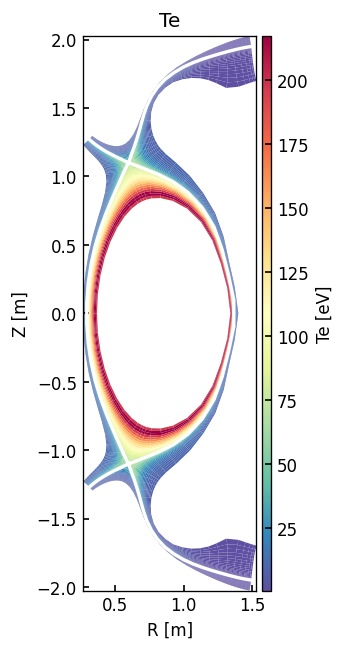

In [55]:
ds = cs["base"].ds.isel(t=-1)

ds["Te"].bout.polygon(cmap = "Spectral_r", antialias = True)